## Predicting Air Quality Index (AQI) Using Machine Learning and Deep Learning Models
*Students* Andrea Thomas, Joseph Edwards, Jinyuan He

# Introduction

Air pollution has become one of the most significant environmental and public health challenges in modern cities. Poor air quality is closely linked to respiratory illness, reduced life expectancy, productivity losses, and increased healthcare burden. For governments, environmental agencies, and businesses, accurate forecasting of air quality is essential for early warnings, public protection, and operational decision-making.

In this project, we focus on predicting the Air Quality Index (AQI) using the **Taiwan Air Quality Dataset (2016–2024)**, an hourly dataset published on Kaggle. Taiwan provides an excellent case study due to its dense urban centers, complex topography, and highly variable meteorological patterns influenced by monsoon seasons, typhoons, long-range dust transport, and industrial activity. These unique characteristics make AQI prediction both scientifically interesting and practically important.

The goal of this project is to build a complete machine learning pipeline to forecast hourly AQI values based on historical pollutant concentrations and weather conditions. We construct models from three categories:

- **Baseline Model:** Linear Regression  
- **Tree-Based Models:** Random Forest and XGBoost  
- **Deep Learning Sequence Models:** Feedforward Neural Network (FNN) and Long Short-Term Memory (LSTM)

By comparing these approaches, we aim to understand:
1. Which model family performs best for Taiwan's AQI patterns  
2. Which pollutant and meteorological variables contribute most to prediction accuracy  
3. How temporal dependencies (lag features and sequences) influence forecasting quality  

This notebook includes end-to-end steps:
- Data loading and exploratory analysis  
- Feature engineering (time features, lag features, rolling windows)  
- Model development across ML and DL techniques  
- Evaluation with MAE, RMSE, and R²  
- Visualization of predictions and feature importances  

Ultimately, this project provides a practical and data-driven approach to AQI forecasting tailored to Taiwan's environmental context, demonstrating how machine learning and deep learning can support smarter air-quality monitoring and early-warning systems.



# 1. Data Loading & Cleaning

In [ ]:
# install kagglehub if needs
#!pip install kagglehub[pandas-datasets]

In [1]:
import kagglehub
import pandas as pd
import numpy as np

# Download the dataset (KaggleHub returns the local directory path)
local_dir = kagglehub.dataset_download("taweilo/taiwan-air-quality-data-20162024")

print("Downloaded to:", local_dir)

Using Colab cache for faster access to the 'taiwan-air-quality-data-20162024' dataset.
Downloaded to: /kaggle/input/taiwan-air-quality-data-20162024


In [2]:
df = pd.read_csv(f"{local_dir}/air_quality.csv")
df.head()

/tmp/ipython-input-241818074.py:1: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,15,16,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{local_dir}/air_quality.csv")


,date,sitename,county,aqi,pollutant,status,so2,co,o3,o3_8hr,...,windspeed,winddirec,unit,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid
0,2024-08-31 23:00,Hukou,Hsinchu County,62.0,PM2.5,Moderate,0.9,0.17,35.0,40.2,...,2.3,225,NaN,0.2,20.1,26.0,1.0,121.038869,24.900097,22.0
1,2024-08-31 23:00,Zhongming,Taichung City,50.0,NaN,Good,1.6,0.32,27.9,35.1,...,1.1,184,NaN,0.2,15.3,23.0,1.0,120.641092,24.151958,31.0
2,2024-08-31 23:00,Zhudong,Hsinchu County,45.0,NaN,Good,0.4,0.17,25.1,40.6,...,0.4,210,NaN,0.2,13.8,24.0,0.0,121.088955,24.740914,23.0
3,2024-08-31 23:00,Hsinchu,Hsinchu City,42.0,NaN,Good,0.8,0.2,30.0,35.9,...,1.9,239,NaN,0.2,13.0,26.0,1.0,120.972368,24.805636,24.0
4,2024-08-31 23:00,Toufen,Miaoli County,50.0,NaN,Good,1.0,0.16,33.5,35.9,...,1.8,259,NaN,0.1,15.3,28.0,1.0,120.898693,24.696907,25.0


In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
for col in df.columns:
    if col not in ['date', 'sitename', 'county', 'pollutant', 'status', 'unit']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Data types after numeric conversion:")
df.info()

In [35]:
# Drop the siteid and date is missing
df = df.dropna(subset=['siteid', 'date'])

initial_count = len(df)
df = df.dropna(subset=['siteid'])
print(f"Drop missing siteid from: {len(df):,} rows (dropped {initial_count - len(df):,} rows)")

# fill location with median value
if 'siteid' in df.columns and 'latitude' in df.columns:
    # calculate median
    station_coords = df.groupby('siteid')[['latitude', 'longitude']].median()

    # fill up the missing values
    for siteid in df['siteid'].unique():
        mask = (df['siteid'] == siteid) & (df['latitude'].isna())
        if mask.any() and siteid in station_coords.index:
            df.loc[mask, 'latitude'] = station_coords.loc[siteid, 'latitude']
            df.loc[mask, 'longitude'] = station_coords.loc[siteid, 'longitude']

    print(f"After filled up，latitude still missing: {df['latitude'].isna().sum()}")

Drop missing siteid from: 4,102,739 rows (dropped 0 rows)


In [12]:
def clean_wide_format_data(df):
    """
    清洗宽格式的空气质量数据
    """
    df = df.copy()

    print("="*50)
    print("开始数据清洗")
    print("="*50)

    # 1. 识别关键列
    # 时间列可能的名字
    time_cols = ['date', 'datetime', 'time', 'timestamp', 'publishtime']
    time_col = None
    for col in time_cols:
        if col in df.columns:
            time_col = col
            break

    if time_col is None:
        print("警告：未找到时间列！")
        return None

    print(f"\n✓ 找到时间列: {time_col}")

    # 2. 转换时间格式
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

    # 3. 删除时间为空的行
    df = df.dropna(subset=[time_col])
    print(f"✓ 删除时间缺失后: {len(df):,} 行")

    # 4. 处理 siteid
    if 'siteid' in df.columns:
        # siteid 缺失的可能可以通过其他信息恢复
        # 但如果无法恢复，就删除
        initial_count = len(df)
        df = df.dropna(subset=['siteid'])
        print(f"✓ 删除 siteid 缺失后: {len(df):,} 行 (删除了 {initial_count - len(df):,} 行)")

    # 5. 删除完全空的列（unit, pollutant 等元数据列）
    df = df.dropna(axis=1, how='all')
    print(f"✓ 删除完全空的列后: {len(df.columns)} 列")

    # 6. 处理坐标缺失 - 用 siteid 的平均值填充
    if 'siteid' in df.columns and 'latitude' in df.columns:
        # 计算每个测站的平均坐标
        station_coords = df.groupby('siteid')[['latitude', 'longitude']].median()

        # 填充缺失的坐标
        for siteid in df['siteid'].unique():
            mask = (df['siteid'] == siteid) & (df['latitude'].isna())
            if mask.any() and siteid in station_coords.index:
                df.loc[mask, 'latitude'] = station_coords.loc[siteid, 'latitude']
                df.loc[mask, 'longitude'] = station_coords.loc[siteid, 'longitude']

        print(f"✓ 填充坐标后，latitude 缺失: {df['latitude'].isna().sum()}")

    # 7. 识别污染物列
    pollutant_patterns = ['pm2.5', 'pm10', 'o3', 'no2', 'so2', 'co', 'no', 'nox']
    pollutant_cols = []
    for col in df.columns:
        if any(pattern in col.lower() for pattern in pollutant_patterns):
            pollutant_cols.append(col)

    print(f"\n✓ 找到 {len(pollutant_cols)} 个污染物相关列:")
    for col in pollutant_cols:
        missing_pct = df[col].isna().sum() / len(df) * 100
        print(f"  - {col}: {missing_pct:.2f}% 缺失")

    # 8. 选择主要污染物（缺失率<15%）
    main_pollutants = [col for col in pollutant_cols
                       if df[col].isna().sum() / len(df) < 0.15]

    print(f"\n✓ 选择缺失率<15%的主要污染物: {len(main_pollutants)} 个")
    print(f"  {main_pollutants}")

    # 9. 保留关键列
    cols_to_keep = [time_col] + ['siteid', 'latitude', 'longitude'] + main_pollutants
    cols_to_keep = [col for col in cols_to_keep if col in df.columns]

    df_clean = df[cols_to_keep].copy()

    # 10. 按时间和测站排序
    sort_cols = [time_col]
    if 'siteid' in df_clean.columns:
        sort_cols.insert(0, 'siteid')
    df_clean = df_clean.sort_values(sort_cols)

    print(f"\n{'='*50}")
    print("清洗完成！")
    print(f"{'='*50}")
    print(f"最终数据: {len(df_clean):,} 行 × {len(df_clean.columns)} 列")
    print(f"时间范围: {df_clean[time_col].min()} 到 {df_clean[time_col].max()}")

    if 'siteid' in df_clean.columns:
        print(f"测站数量: {df_clean['siteid'].nunique()}")

    return df_clean, time_col, main_pollutants

# 执行清洗
df_clean, time_col, pollutant_cols = clean_wide_format_data(df)

开始数据清洗

✓ 找到时间列: date
✓ 删除时间缺失后: 5,882,123 行
✓ 删除 siteid 缺失后: 4,102,654 行 (删除了 1,779,469 行)
✓ 删除完全空的列后: 24 列
✓ 填充坐标后，latitude 缺失: 0

✓ 找到 14 个污染物相关列:
  - county: 0.00% 缺失
  - so2: 2.36% 缺失
  - co: 1.63% 缺失
  - o3: 2.16% 缺失
  - o3_8hr: 1.50% 缺失
  - pm10: 2.11% 缺失
  - pm2.5: 2.11% 缺失
  - no2: 2.72% 缺失
  - nox: 2.73% 缺失
  - no: 2.74% 缺失
  - co_8hr: 0.89% 缺失
  - pm2.5_avg: 1.30% 缺失
  - pm10_avg: 1.26% 缺失
  - so2_avg: 1.22% 缺失

✓ 选择缺失率<15%的主要污染物: 14 个
  ['county', 'so2', 'co', 'o3', 'o3_8hr', 'pm10', 'pm2.5', 'no2', 'nox', 'no', 'co_8hr', 'pm2.5_avg', 'pm10_avg', 'so2_avg']

清洗完成！
最终数据: 4,102,654 行 × 18 列
时间范围: 2019-07-15 12:00:00 到 2024-08-31 23:00:00
测站数量: 98



清洗后的缺失情况:
              Column  Missing_Count  Missing_Percentage
so2              so2          96860                2.36
co                co          67050                1.63
o3                o3          88541                2.16
o3_8hr        o3_8hr          61604                1.50
pm10            pm10          86536                2.11
pm2.5          pm2.5          86589                2.11
no2              no2         111735                2.72
nox              nox         111973                2.73
no                no         112303                2.74
co_8hr        co_8hr          36317                0.89
pm2.5_avg  pm2.5_avg          53297                1.30
pm10_avg    pm10_avg          51729                1.26
so2_avg      so2_avg          49866                1.22


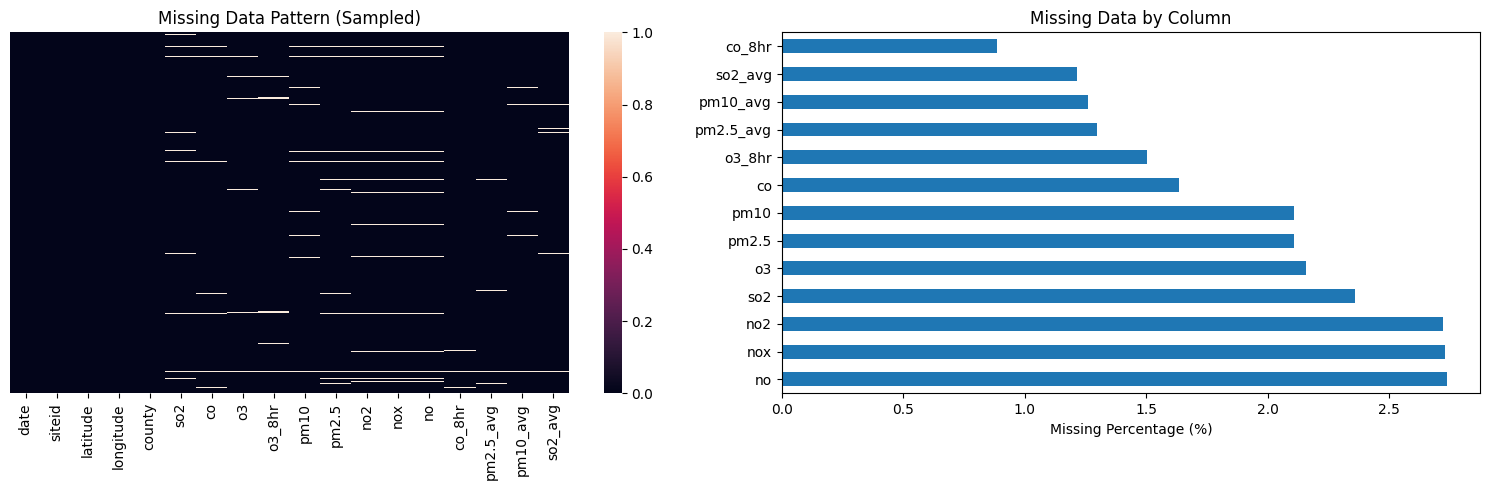

In [15]:
# 查看清洗后的缺失情况
print("\n清洗后的缺失情况:")
missing_after = pd.DataFrame({
    'Column': df_clean.columns,
    'Missing_Count': df_clean.isnull().sum(),
    'Missing_Percentage': (df_clean.isnull().sum() / len(df_clean) * 100).round(2)
})
print(missing_after[missing_after['Missing_Count'] > 0])

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 缺失数据热图
sns.heatmap(df_clean.isnull().iloc[::100], # 每100行采样一次以提高速度
            cbar=True,
            yticklabels=False,
            ax=axes[0])
axes[0].set_title('Missing Data Pattern (Sampled)')

# 缺失比例柱状图
missing_pct = (df_clean.isnull().sum() / len(df_clean) * 100)
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)
missing_pct.plot(kind='barh', ax=axes[1])
axes[1].set_xlabel('Missing Percentage (%)')
axes[1].set_title('Missing Data by Column')

plt.tight_layout()
plt.show()


In [18]:
if 'siteid' in df_clean.columns:
    # 每个测站的数据完整性
    station_quality = []

    for station in df_clean['siteid'].unique():
        station_df = df_clean[df_clean['siteid'] == station]

        total_cells = len(station_df) * len(pollutant_cols)
        missing_cells = station_df[pollutant_cols].isna().sum().sum()
        completeness = (1 - missing_cells / total_cells) * 100

        station_quality.append({
            'siteid': station,
            'rows': len(station_df),
            'completeness': completeness,
            'time_span_days': (station_df[time_col].max() - station_df[time_col].min()).days
        })

    station_quality_df = pd.DataFrame(station_quality).sort_values('completeness', ascending=False)

    print("\n前10个数据质量最好的测站：")
    print(station_quality_df.head(10))

    print("\n推荐用于建模的测站（完整性>85%，时间跨度>365天）：")
    good_stations = station_quality_df[
        (station_quality_df['completeness'] > 85) &
        (station_quality_df['time_span_days'] > 365)
    ]
    print(good_stations)


前10个数据质量最好的测站：
    siteid  rows  completeness  time_span_days
84    87.0    21         100.0               7
55    55.0    21         100.0               7
92   206.0     1         100.0               0
74    74.0    21         100.0               7
76    76.0    21         100.0               7
87    96.0    21         100.0               7
86    92.0    21         100.0               7
85    90.0    19         100.0               7
73    73.0    21         100.0               7
83    86.0    19         100.0               7

推荐用于建模的测站（完整性>85%，时间跨度>365天）：
    siteid   rows  completeness  time_span_days
42    42.0  48905     99.010764            1874
48    48.0  48909     98.905109            1874
8      8.0  48906     98.882404            1874
45    45.0  48904     98.874763            1874
28    28.0  48908     98.871058            1874
..     ...    ...           ...             ...
91   204.0  48721     96.703680            1874
67    67.0  48894     96.587516            1874
82  

In [6]:
import pandas as pd
import numpy as np

def prepare_aqi_lstm_data(df, feature_cols, target_col, window=24):

    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # 排序
    df = df.sort_values(["siteid", "date"]).copy()

    # 计算每个站点内部的时间差
    df["time_diff"] = df.groupby("siteid")["date"].diff()

    # =========================
    # Step 1: 小缺失（≤2 小时）插值
    # =========================
    # 小缺失定义
    small_gap = pd.Timedelta(hours=2)

    # 标记是否为大缺失
    df["is_big_gap"] = df["time_diff"] > small_gap

    # 对每个站点进行插值
    def interpolate_small_gaps(group):
        # 对非大缺失的时间点插值
        group.loc[~group["is_big_gap"], feature_cols] = (
            group.loc[~group["is_big_gap"], feature_cols]
            .interpolate(method="linear")
        )
        return group

    df = df.groupby("siteid").apply(interpolate_small_gaps).reset_index(drop=True)

    # =========================
    # Step 2: 大缺失（>2小时）切段
    # =========================
    df["segment_id"] = df.groupby("siteid")["is_big_gap"].apply(
        lambda s: s.cumsum()
    )

    # 现在 segment_id 在每个站点内表示连续片段

    # =========================
    # Step 3: 对每个 segment 生成窗口
    # =========================
    X, Y = [], []

    for (site_id, seg_id), group in df.groupby(["siteid", "segment_id"]):
        group = group.sort_values("date")

        # 丢掉太短的段（不足 24 小时）
        if len(group) <= window:
            continue

        vals = group[feature_cols].values
        targets = group[target_col].values

        for i in range(len(group) - window):
            X.append(vals[i:i+window])
            Y.append(targets[i+window])

    return np.array(X), np.array(Y), df

feature_cols = ["aqi", "windspeed"]
target_col = "aqi"

X, Y, processed_df = prepare_aqi_lstm_data(
    df,
    feature_cols=feature_cols,
    target_col=target_col,
    window=24
)


/tmp/ipython-input-2928390771.py:28: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  .interpolate(method="linear")
/tmp/ipython-input-2928390771.py:28: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  .interpolate(method="linear")
/tmp/ipython-input-2928390771.py:28: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  .interpolate(method="linear")
/tmp/ipython-input-2928390771.py:28: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  .interpolate(method="linear")
/tmp/ipython-input-2928390771.py:28: FutureW

TypeError: incompatible index of inserted column with frame index

In [ ]:

# Compute time differences per site
df_cleaned["time_diff"] = df_cleaned.groupby("siteid")["date"].diff()

# Find gaps > 4 hours
missing_gaps = df_cleaned[df_cleaned["time_diff"] > pd.Timedelta(hours=4)]

# Count number of gaps per siteid
gap_counts = missing_gaps.groupby("siteid").size()

# List of all siteids
all_siteids = df_cleaned["siteid"].unique()

# Siteids that have NO gaps
siteids_no_gaps = [sid for sid in all_siteids if sid not in gap_counts.index]

print("Site IDs with NO missing gaps > 4 hours:")
print(siteids_no_gaps)

Site IDs with NO missing gaps > 4 hours:
[np.int64(0)]


# Task
Convert the 'date' column of the DataFrame to datetime objects, coercing errors. Then, convert all other applicable columns to numeric types, coercing errors, to ensure all pollutant, AQI, and other quantitative measures are numerically represented. Finally, display the data types of all columns to confirm the conversions.

## Convert Date Column to Datetime

### Subtask:
Convert the 'date' column in the DataFrame to a datetime object, coercing any errors to NaN to handle problematic entries gracefully.


**Reasoning**:
The user wants to convert the 'date' column to datetime objects using `pd.to_datetime()` with `errors='coerce'` and then display the head of the DataFrame to verify the conversion.



**Reasoning**:
The previous step converted the 'date' column. Now, the subtask requires converting all other applicable columns to numeric types, coercing errors, and then displaying the data types to confirm. I will iterate through all columns except known string/object columns ('sitename', 'county', 'pollutant', 'status', 'unit', and the already converted 'date') and attempt to convert them to numeric, coercing any errors to NaN.



Data types after numeric conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5882208 entries, 0 to 5882207
Data columns (total 25 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   sitename   object        
 2   county     object        
 3   aqi        float64       
 4   pollutant  object        
 5   status     object        
 6   so2        float64       
 7   co         float64       
 8   o3         float64       
 9   o3_8hr     float64       
 10  pm10       float64       
 11  pm2.5      float64       
 12  no2        float64       
 13  nox        float64       
 14  no         float64       
 15  windspeed  float64       
 16  winddirec  float64       
 17  unit       float64       
 18  co_8hr     float64       
 19  pm2.5_avg  float64       
 20  pm10_avg   float64       
 21  so2_avg    float64       
 22  longitude  float64       
 23  latitude   float64       
 24  siteid     float64       
dtypes: datet